# Modern Portfolio Theory - Balance between Crypto, Stocks, Bonds

MPT is about achieving the optimal balance between risk and reward through diversification


The main goal of MPT is to maximize returns while mitigating risks.



In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [2]:
# Define your assets
cryptos = ['BTC-USD', 'ETH-USD', 'SOL-USD']
stocks = ['AAPL', 'MSFT', 'GOOGL']
bonds = ['BND', 'TLT']

assets = cryptos + stocks + bonds

# Define the start and end dates
start_date = '2022-01-01'
end_date = '2024-01-01'

# Download data for the assets
data = yf.download(assets, start=start_date, end=end_date)['Adj Close']


[*********************100%%**********************]  8 of 8 completed


## Data Analysis

In [3]:
# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Display the first few rows of the returns dataframe
print(returns.head())


Ticker          AAPL       BND   BTC-USD   ETH-USD     GOOGL      MSFT  \
Date                                                                     
2022-01-04 -0.012692 -0.000119 -0.012066  0.008687 -0.004083 -0.017147   
2022-01-05 -0.026600 -0.003446 -0.050734 -0.064224 -0.045876 -0.038388   
2022-01-06 -0.016693 -0.001072 -0.009366 -0.037173 -0.000200 -0.007902   
2022-01-07  0.000988 -0.002745 -0.037141 -0.065878 -0.005303  0.000510   
2022-01-08  0.000000  0.000000  0.004236 -0.031704  0.000000  0.000000   

Ticker       SOL-USD       TLT  
Date                            
2022-01-04 -0.013851 -0.004158  
2022-01-05 -0.076451 -0.005428  
2022-01-06 -0.030099  0.002589  
2022-01-07 -0.093255 -0.007188  
2022-01-08  0.044798  0.000000  


/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_89426/3866938461.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


## Portfolio Optimization

In [4]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, risk

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_returns, p_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_risk

def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0.01):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    result = minimize(negative_sharpe_ratio, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Optimize the portfolio
result = optimize_portfolio(mean_returns, cov_matrix)
optimal_weights = result.x
print('Optimal Weights:', optimal_weights)


Optimal Weights: [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.16333634e-17
 0.00000000e+00 0.00000000e+00 1.00000000e+00 3.73136602e-17]


## Visualization

/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_89426/2558250399.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(max_sharpe_port[0], max_sharpe_port[1], marker='*', color='r', s=500, label='Max Sharpe Ratio')
/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_89426/2558250399.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(min_risk_port[0], min_risk_port[1], marker='*', color='b', s=500, label='Min Risk')


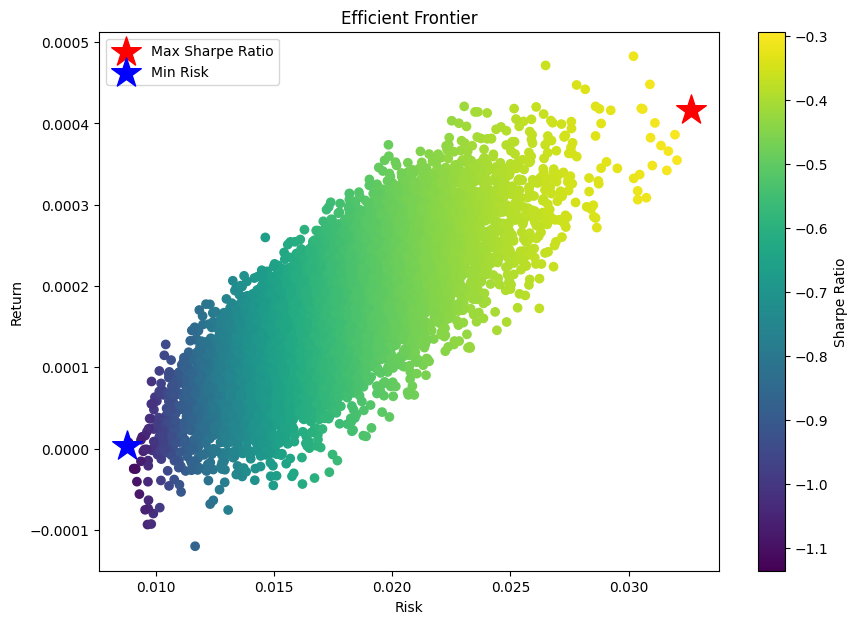

In [5]:
def plot_efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0.01):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_risk
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_risk

    results_frame = pd.DataFrame(results.T, columns=['Risk','Return','Sharpe'])
    weights_frame = pd.DataFrame(weights_record, columns=assets)

    max_sharpe_idx = results_frame['Sharpe'].idxmax()
    max_sharpe_port = results_frame.iloc[max_sharpe_idx]
    min_risk_idx = results_frame['Risk'].idxmin()
    min_risk_port = results_frame.iloc[min_risk_idx]

    plt.figure(figsize=(10, 7))
    plt.scatter(results_frame.Risk, results_frame.Return, c=results_frame.Sharpe, cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe_port[0], max_sharpe_port[1], marker='*', color='r', s=500, label='Max Sharpe Ratio')
    plt.scatter(min_risk_port[0], min_risk_port[1], marker='*', color='b', s=500, label='Min Risk')
    plt.title('Efficient Frontier')
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

# Plot efficient frontier
plot_efficient_frontier(mean_returns, cov_matrix)


## Backtesting

/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_89426/3427245200.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  portfolio_returns = (data[assets].pct_change().dropna() * weights).sum(axis=1)


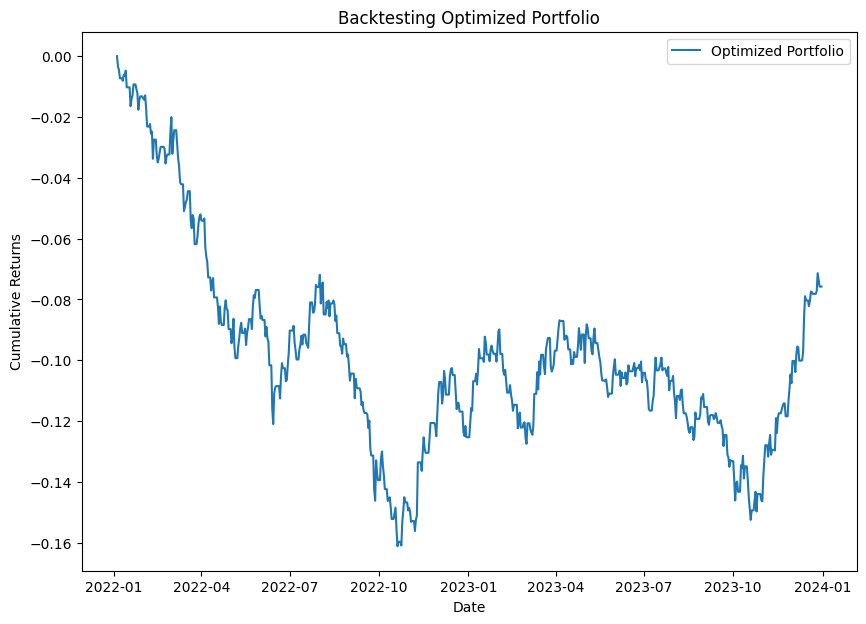

In [6]:
def backtest_portfolio(data, weights):
    portfolio_returns = (data[assets].pct_change().dropna() * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1

    plt.figure(figsize=(10, 7))
    plt.plot(cumulative_returns, label='Optimized Portfolio')
    plt.title('Backtesting Optimized Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

# Backtest the optimized portfolio
backtest_portfolio(data, optimal_weights)


## Sensitivity Analysis

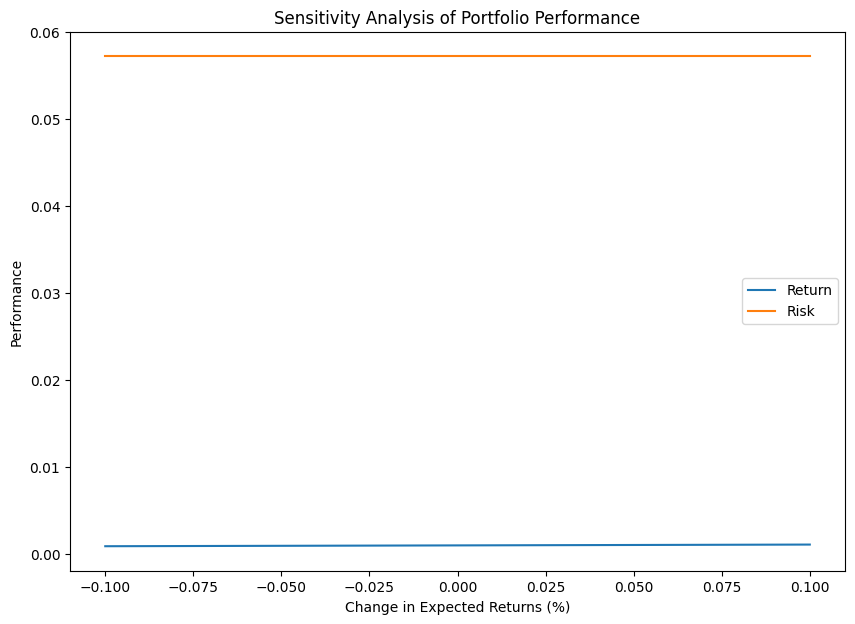

In [7]:
def sensitivity_analysis(mean_returns, cov_matrix, risk_free_rate=0.01):
    sensitivity_results = []
    for delta in np.linspace(-0.1, 0.1, 10):  # Adjust the delta range as needed
        adjusted_returns = mean_returns * (1 + delta)
        result = optimize_portfolio(adjusted_returns, cov_matrix, risk_free_rate)
        optimal_weights = result.x
        portfolio_return, portfolio_risk = portfolio_performance(optimal_weights, adjusted_returns, cov_matrix)
        sensitivity_results.append((delta, portfolio_return, portfolio_risk))

    sensitivity_df = pd.DataFrame(sensitivity_results, columns=['Delta', 'Return', 'Risk'])
    
    plt.figure(figsize=(10, 7))
    plt.plot(sensitivity_df['Delta'], sensitivity_df['Return'], label='Return')
    plt.plot(sensitivity_df['Delta'], sensitivity_df['Risk'], label='Risk')
    plt.title('Sensitivity Analysis of Portfolio Performance')
    plt.xlabel('Change in Expected Returns (%)')
    plt.ylabel('Performance')
    plt.legend()
    plt.show()

# Perform sensitivity analysis
sensitivity_analysis(mean_returns, cov_matrix)
